In [338]:
using LinearAlgebra
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using GalacticOptim
using Plots
using Zygote
using BenchmarkTools
using CUDA
using Printf
using MLUtils
using IterTools: ncycle
using BSON: @save, @load

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/utils/processing_tools.jl")
include("src/neural_ode/objectives.jl")
include("src/neural_ode/models.jl")
include("src/neural_ode/regularization.jl")
include("src/rom/pod.jl")

Main.POD

# Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

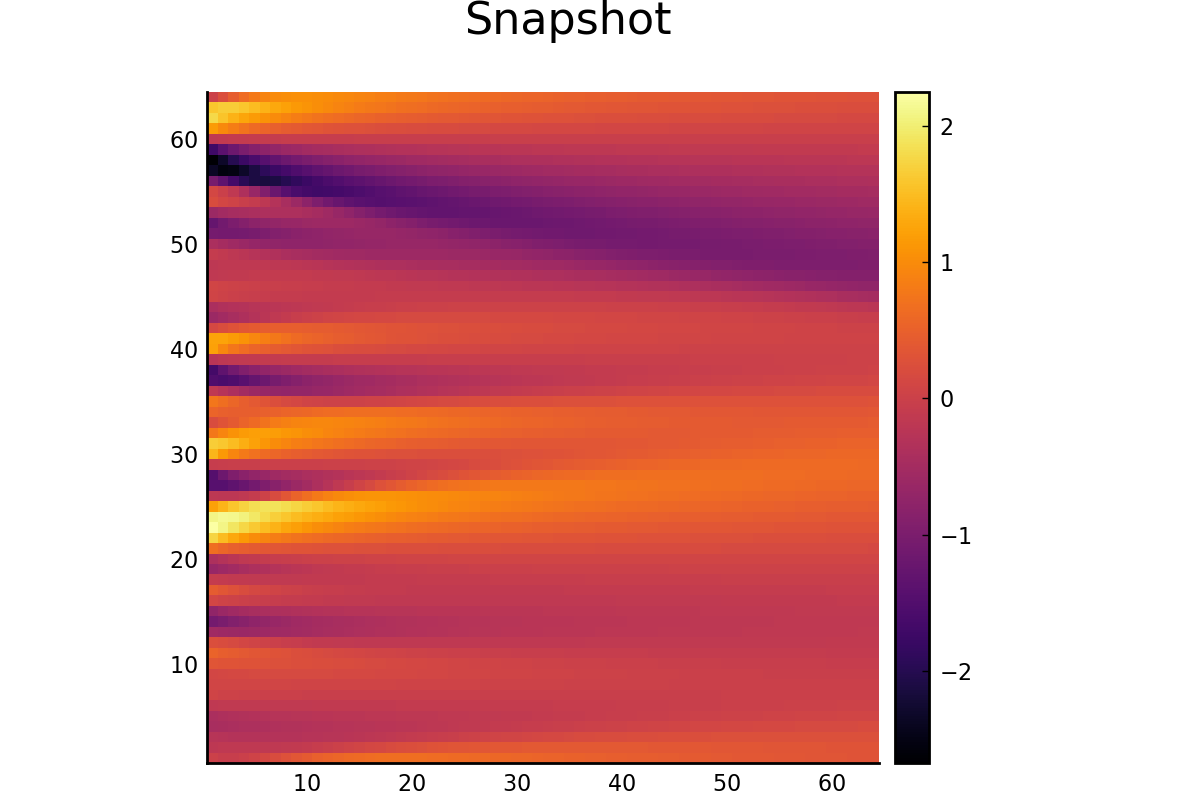

In [336]:
t_max = 0.5;
t_min = 0.;
x_max = pi;
x_min = 0.;
t_n = 64;
x_n = 64;

nu = 0.03;

dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);


u0 = InitialFunctions.high_dim_random_init(t, x, 28);
t, u = Equations.get_burgers_fft(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u, "Snapshot") # need to reverse u, odesolver switch dimensions

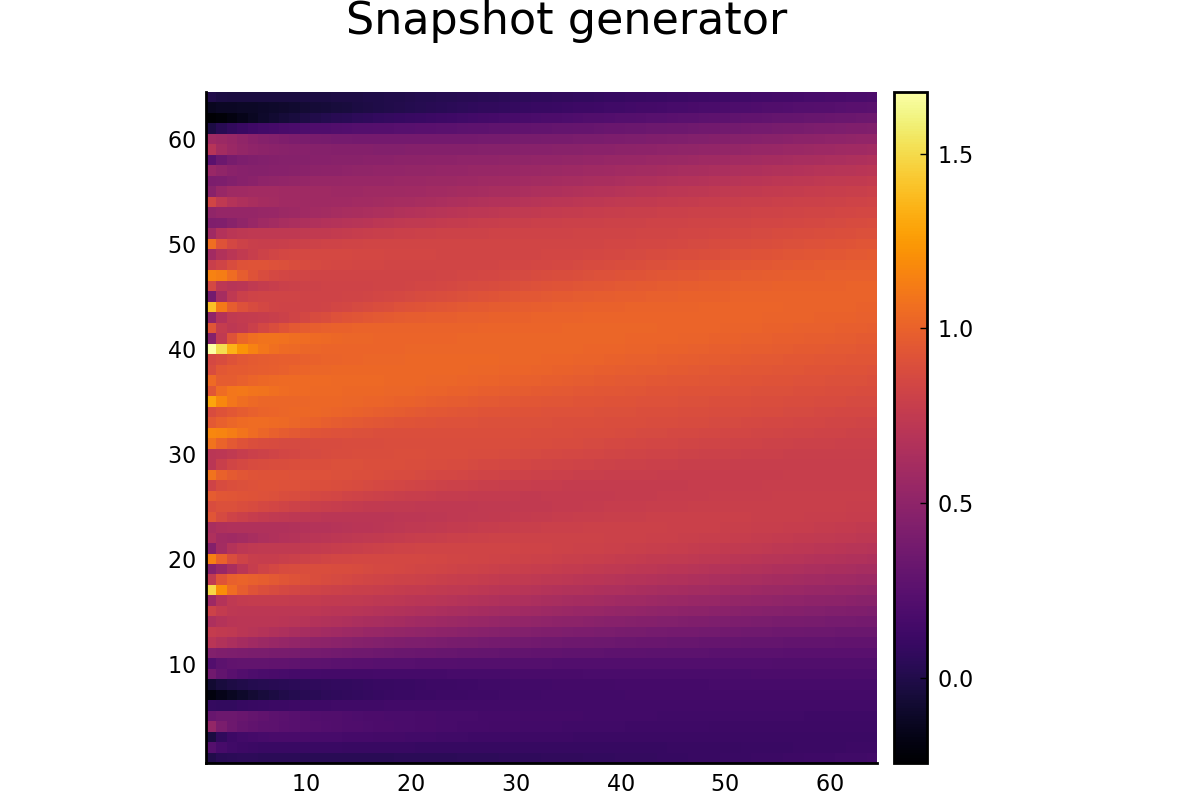

In [113]:
ta, u_a = Generator.burgers_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, nu, 1);
GraphicTools.show_state(u_a, "Snapshot generator")

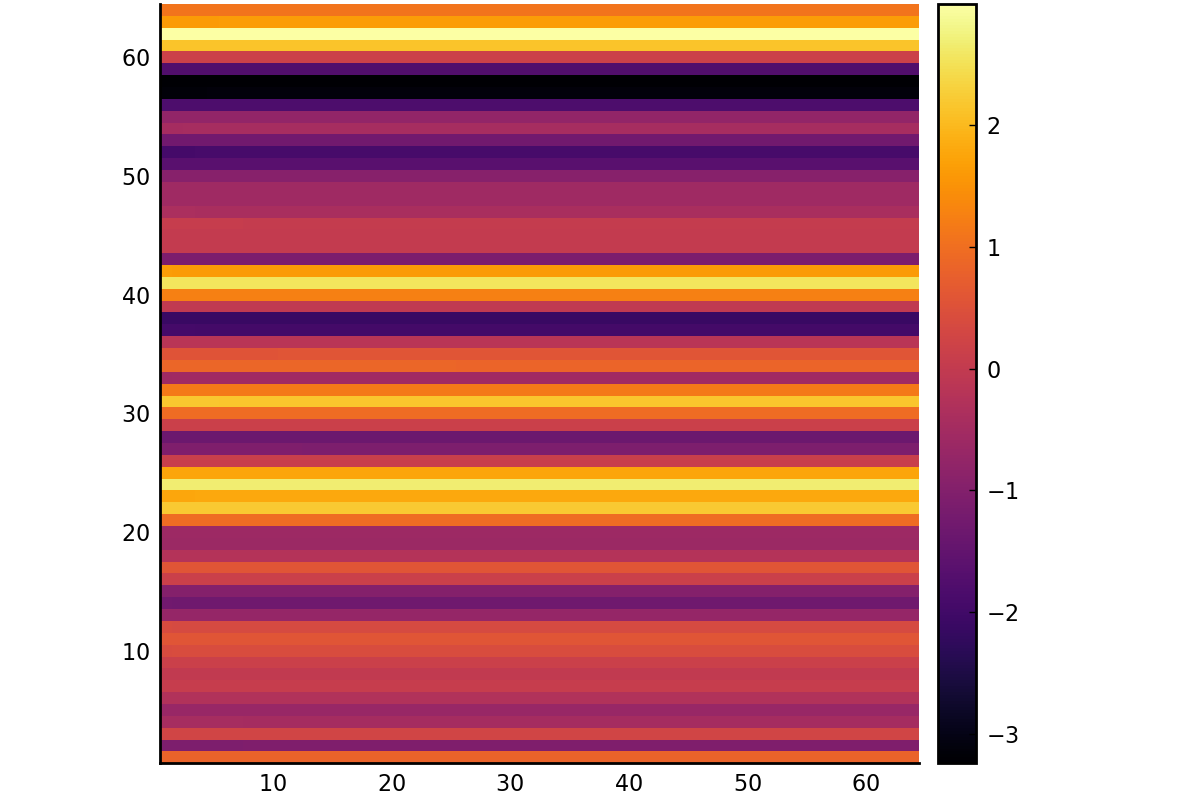

In [339]:
bas = POD.generate_pod_basis(u, true);
ϕ = bas.modes;
res = Equations.galerkin_projection(t, u, ϕ, nu, dx, dt);
GraphicTools.show_state(res, "")

In [162]:
# dataset = Generator.generate_burgers_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, nu, 128, 2, 1, false, "./src/dataset/burgers_high_dim_training_set.jld2", "training_set");
high_dataset = Generator.read_dataset("./src/dataset/burgers_high_dim_training_set.jld2")["training_set"];
# coarse_dataset = Generator.read_dataset("./src/dataset/burgers_coarse_training_set.jld2")["training_set"];

Item1Item2Item3Item4Item5Item6Item7Item8Item9Item10Item11Item12Item13Item14Item15Item16Item17Item18Item19Item20Item21Item22Item23Item24Item25Item26Item27Item28Item29Item30Item31Item32Item33Item34Item35Item36Item37Item38Item39Item40Item41Item42Item43Item44Item45Item46Item47Item48Item49Item50Item51Item52Item53Item54Item55Item56Item57Item58Item59Item60Item61Item62Item63Item64Item65Item66Item67Item68Item69Item70Item71Item72Item73Item74Item75Item76Item77Item78Item79Item80Item81Item82Item83Item84Item85Item86Item87Item88Item89Item90Item91Item92Item93Item94Item95Item96Item97Item98Item99Item100Item101Item102Item103Item104Item105Item106Item107Item108Item109Item110Item111Item112Item113Item114Item115Item116Item117Item118Item119Item120Item121Item122Item123Item124Item125Item126Item127Item128

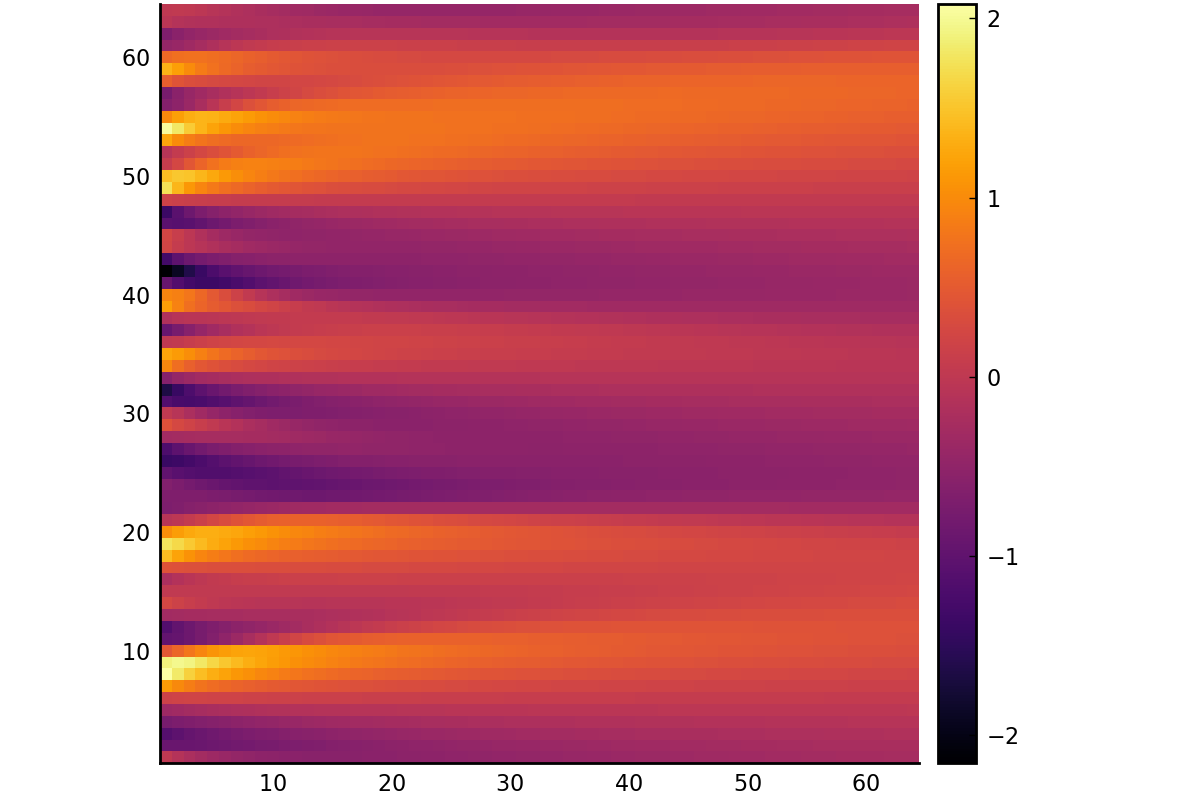

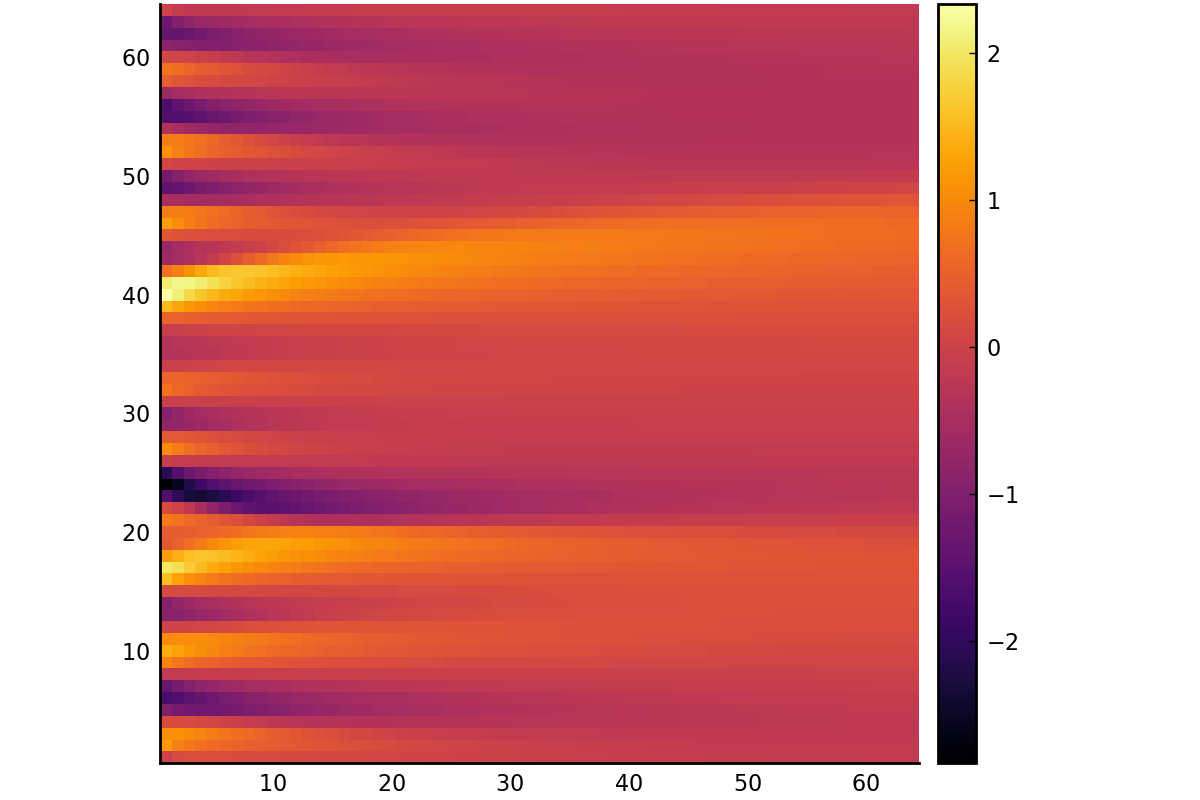

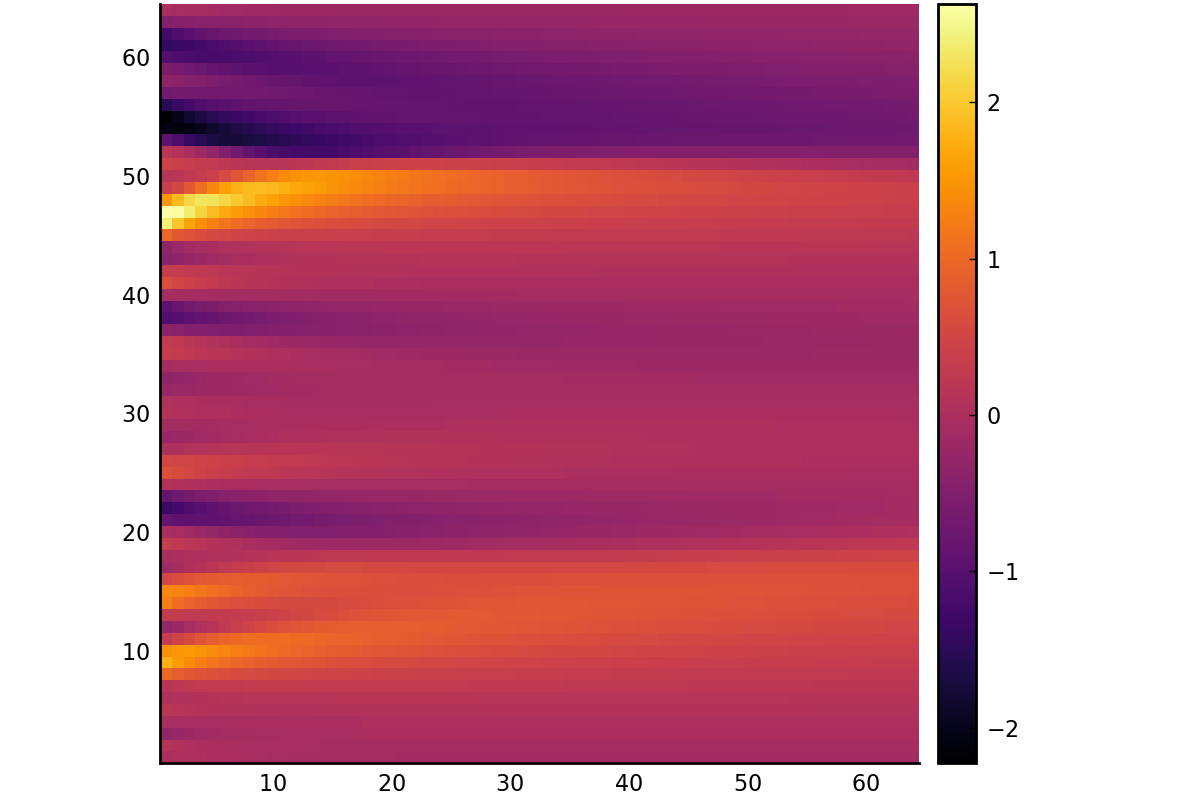

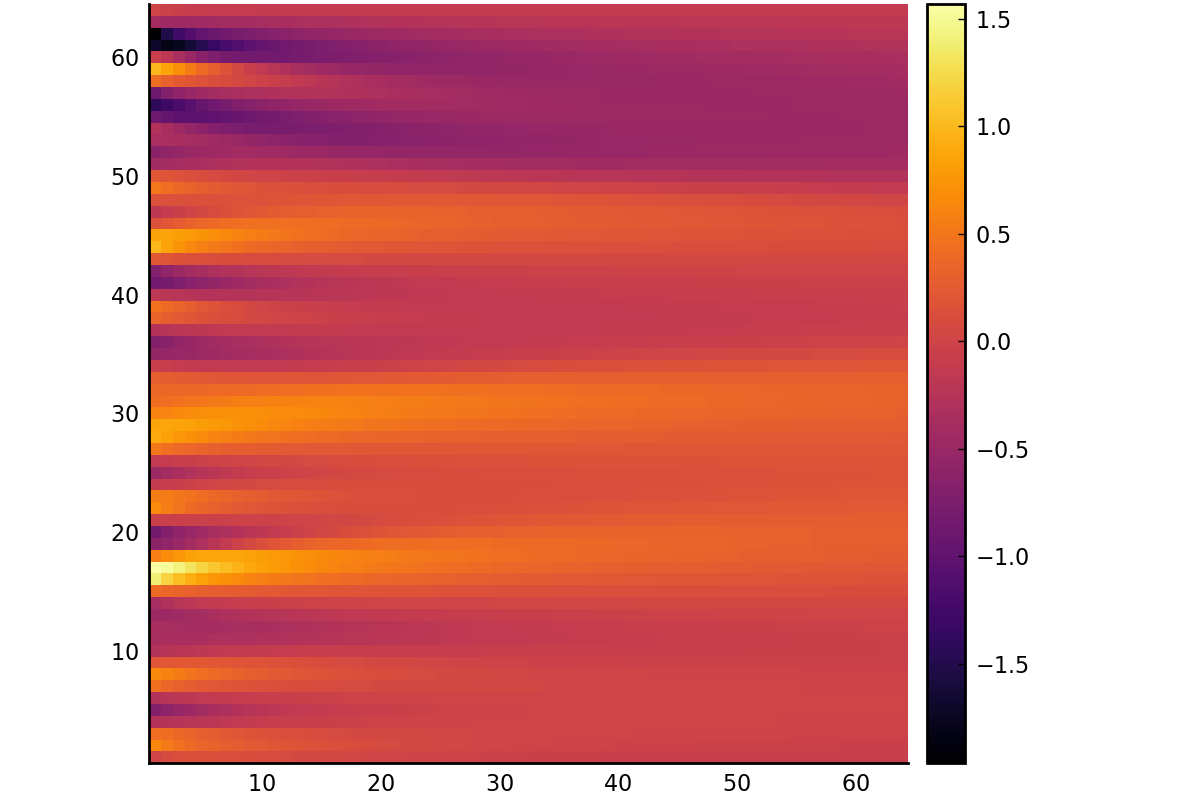

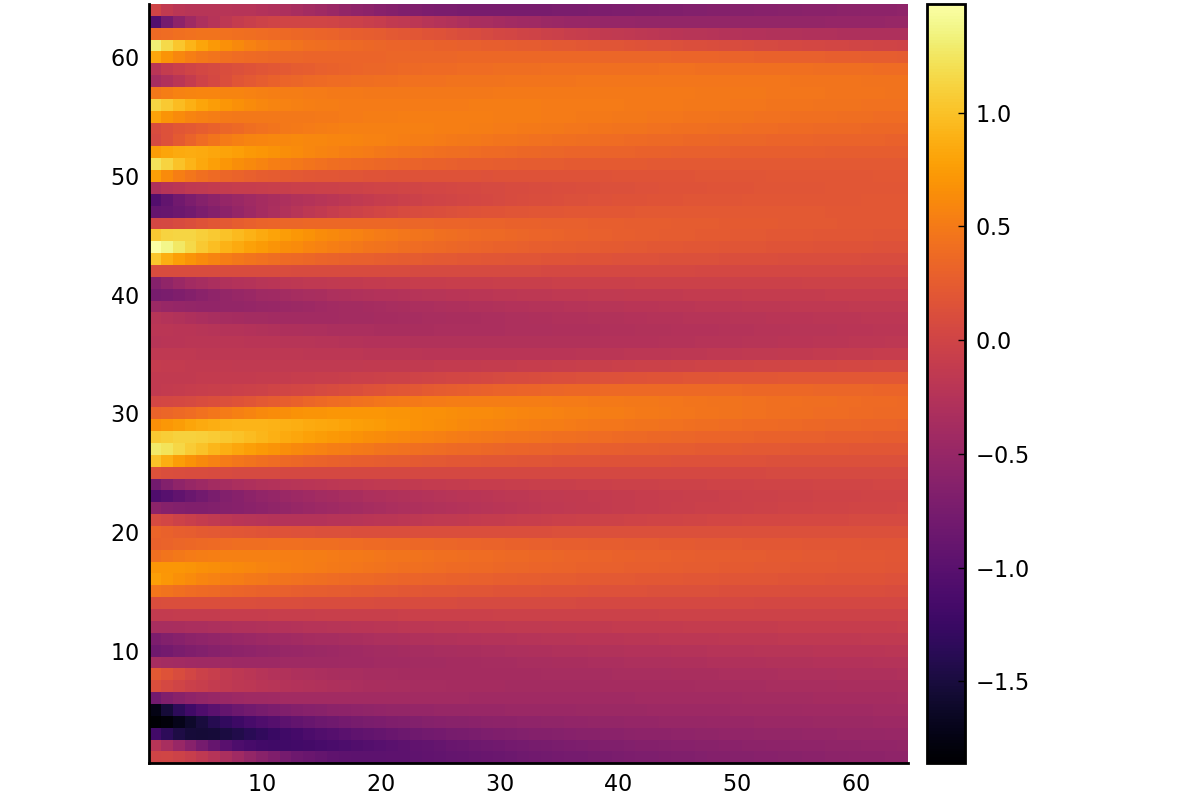

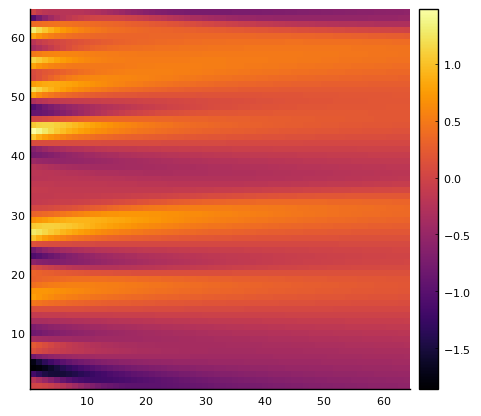

In [166]:
function check_training_dataset(dataset)
    for i in range(1, 3, step=1)
        a, b = dataset[i];
        display(GraphicTools.show_state(b, ""))
    end
end

check_training_dataset(high_dataset)

--- 
# Training with NeuralODE object (DISCARDED)

In [ ]:
callback(theta, loss, u) = (display(loss); false)

In [ ]:
function burgers_training(net, epochs, u0, u_true, t)
  optimizer = DiffEqFlux.ADAM(0.03, (0.9, 0.999), 1.0e-8)
  
  tspan = (t[1], t[end])
  neural_ode = NeuralODE(net, tspan, Tsit5(), saveat=t)

  function predict_neural_ode(theta)
    return Array(neural_ode(u0, theta))
  end

  function loss(theta)
    u_pred = predict_neural_ode(theta)
    noise = 1e-6 .* randn(size(u_pred))
    l = Objectives.mseloss(u_pred + noise, u_true)
    return l, u_pred
  end

  result = DiffEqFlux.sciml_train(loss, neural_ode.p, optimizer; cb = callback, maxiters = epochs);
  return result
end

## Experiment with different models

### Heat linear model

In [ ]:
t, init_set, true_set = ProcessingTools.process_dataset(high_dataset, false);
net = Models.HeatModel(x_n);
result = burgers_training(net, 100, init_set, true_set, t);

In [ ]:
K = reshape(result, (x_n, x_n))
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));  # S function at bottom of notebook

plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, ""),
    GraphicTools.show_state((u_pred .- u), "");
    layout = (1, 3),
)

##### Operator reconstructed

Visualize reconstructed operator and check efficiency to determine solution from unknown sample

In [ ]:
function f(u, K, t)
  return K * u
end

function S(net, u0, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(f), copy(u0), tspan, net)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

In [ ]:
K = reshape(result, (x_n, x_n))
GraphicTools.show_state(reverse(K; dims = 1), "Operator K")

In [ ]:
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));
plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, "");
    layout = (1, 2),
)

--- 
### FNN

In [ ]:
# t, init_set, true_set = ProcessingTools.process_dataset(high_dataset, false);
net2 = Models.BasicFNN(x_n);
result2 = burgers_training(net2, 100, init_set, true_set, t);

In [ ]:
check_result(net2, result2, 2)

### Basic Autoencoder

In [ ]:
net3 = Models.BasicAutoEncoder(x_n);
result3 = burgers_training(net3, 1000, init_set, true_set, t);

In [ ]:
check_result(net3, result3, 2)

## Analysis

In [ ]:
function test_simulation(net, result, n, typ)
    mse_tot = 0
    l1_tot = 0
    for i in n
        t, u0, u_true = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
        prob_neuralode = DiffEqFlux.NeuralODE(net, (t[1], t[end]), Tsit5(), saveat=t)
        u_pred = prob_neuralode(u0, result)

        mse_tot += Objectives.mseloss(u_pred, u_true)
        l1_tot += sum(abs.(u_pred .- u_true))
    end
    
    return mse_tot / n, l1_tot / n
end

In [ ]:
println(test_simulation(net, result, 1000, 1))
println(test_simulation(net, result, 1000, 2))

In [ ]:
println(test_simulation(net2, result2, 1000, 1))
println(test_simulation(net2, result2, 1000, 2))

In [ ]:
println(test_simulation(net3, result3, 1000, 1))
println(test_simulation(net3, result3, 1000, 2))

--- 
# Training with flux

In [260]:
function check_result(nn, res, typ)
    t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
    prob_neuralode = DiffEqFlux.NeuralODE(nn, (t[1], t[end]), Tsit5(), saveat=t)
    u_pred = prob_neuralode(u0, res)

    plot(
        GraphicTools.show_state(u, ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u, "");
        layout = (1, 3),
    )
end

check_result (generic function with 1 method)

In [272]:
function get_data_loader(dataset, batch_size, ratio, cuda=true)
   if cuda && CUDA.has_cuda()
      device = Flux.gpu
      CUDA.allowscalar(false)
      @info "Training on GPU"
  else
      device = Flux.cpu
      @info "Training on CPU"
  end

  n = size(dataset, 1)
  t, init_set, true_set = ProcessingTools.process_dataset(dataset, false);

  t_train, t_val = splitobs(t, at = ratio);
  train_set, val_set = splitobs(true_set, at = ratio);
  init_train = copy(init_set);
  init_val = copy(val_set[:, :, 1]);

  switch_train_set = permutedims(train_set, (1, 3, 2));
  switch_val_set = permutedims(val_set, (1, 3, 2));

  train_data = (init_train |> device, switch_train_set |> device, collect(ncycle([collect(t_train)], n)))
  val_data = (init_val |> device, switch_val_set |> device,  collect(ncycle([collect(t_val)], n))) #  hcat(repeat([collect(t_val)], n)...)

  train_loader = DataLoader(train_data, batchsize=batch_size, shuffle=true);
  val_loader = DataLoader(val_data, batchsize=batch_size, shuffle=false);

  return (train_loader, val_loader)
end

get_data_loader (generic function with 2 methods)

In [267]:
function training(model, epochs, dataset, batch_size, ratio, noise=0., reg=0., cuda=false)
   if cuda && CUDA.has_cuda()
      device = Flux.gpu
      CUDA.allowscalar(true) # false
      @info "Training on GPU"
  else
      device = Flux.cpu
      @info "Training on CPU"
  end

  model = model |> device
  opt = Flux.Optimiser(Flux.WeightDecay(reg), Flux.ADAM(0.01, (0.9, 0.999), 1.0e-8))
  ltrain = 0.;
  lval = 0.;
  losses = [];

  @info("Loading dataset")
  (train_loader, val_loader) = get_data_loader(dataset, batch_size, ratio);

  @info("Building model")
  p, re = Flux.destructure(model);
  net(u, p, t) = re(p)(u);

  prob = ODEProblem{false}(net, Nothing, (Nothing, Nothing));

  function predict_neural_ode(x, t)
    tspan = (t[1], t[end]);
    _prob = remake(prob; u0=x, p=p, tspan=tspan);
    Array(solve(_prob, AutoTsit5(Rosenbrock23()), u0=x, p=p, saveat=t));
  end

  function loss(x, y, t)
    u_pred = predict_neural_ode(x, t[1]);
    ŷ = Reg.gaussian_augment(u_pred, noise);
    l = Flux.mse(ŷ, permutedims(y, (1, 3, 2))) # + Reg.l2(p, reg);
    return l;
  end

  function traincb()
    ltrain = 0;
    for (x, y, t) in train_loader
      # (x, y, t) = (x, y, t) |> device;
      ltrain += loss(x, y, t);
    end
    ltrain /= (train_loader.nobs / train_loader.batchsize);
    @show(ltrain);
  end

  function val_loss(x, y, t)
    u_pred = predict_neural_ode(x, t[1]);
    ŷ = u_pred;
    l = Flux.mse(ŷ, permutedims(y, (1, 3, 2)))
    return l;
  end

  function evalcb()
    lval = 0;
    for (x, y, t) in val_loader
      # (x, y, t) = (x, y, t) |> device;
      lval += val_loss(x, y, t);
    end
    lval /= (val_loader.nobs / val_loader.batchsize);
    @show(lval);
  end

  @info("Train")
  trigger = Flux.plateau(() -> ltrain, 20; init_score = 1, min_dist = 1f-5);
  Flux.@epochs epochs begin
    Flux.train!(loss, Flux.params(p), train_loader, opt, cb = [traincb, evalcb]);
    trigger() && break;
  end

  return re(p), p, ltrain, lval
end

training (generic function with 4 methods)

In [304]:
function main()
  batch_size = 32;
  epochs = 1000;

  data = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_training_set.jld2")["training_set"];
  model = Models.BasicAutoEncoder(x_n);
  K, p = training(model, epochs, data, batch_size, 0.9, 0.01, 1.0e-6);
  # @save "./src/examples/burgers/models/BurgersLinearModel.bson" K
  return K, p
end

K, p = main()

┌ Info: Training on CPU
└ @ Main In[267]:8
┌ Info: Loading dataset
└ @ Main In[267]:16
┌ Info: Training on CPU
└ @ Main In[272]:8
┌ Info: Building model
└ @ Main In[267]:19
┌ Info: Train
└ @ Main In[267]:65
┌ Info: Epoch 1
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.5961676145645842
lval = 0.00040592660189621
ltrain = 0.5729017694417595
lval = 0.00038123513662400405
ltrain = 0.5540667384160344
lval = 0.00036921318661044933
ltrain = 0.537834850752876
lval = 0.0003620095572823575


┌ Info: Epoch 2
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.524718264484521
lval = 0.0003596881711759038
ltrain = 0.5133655689386784
lval = 0.00035933382719443934
ltrain = 0.5033908444645168
lval = 0.0003611452951140881
ltrain = 0.49418051329826984
lval = 0.0003644001423227762


┌ Info: Epoch 3
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.4855850187695085
lval = 0.0003681242011050456
ltrain = 0.4773957625871101
lval = 0.0003733860448443282
ltrain = 0.4696970599135516
lval = 0.0003799548258138439
ltrain = 0.46211647541225365
lval = 0.00038838271044079777


┌ Info: Epoch 4
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.4548054085037718
lval = 0.0003985502079088459
ltrain = 0.4477060658343119
lval = 0.0004098998638789702
ltrain = 0.44076769245145325
lval = 0.0004208587829412056
ltrain = 0.4339436127394247
lval = 0.00042972944358541623


┌ Info: Epoch 5
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.4272834453250344
lval = 0.0004385263260865865
ltrain = 0.4208304291328625
lval = 0.0004463484176756153
ltrain = 0.41445510568864674
lval = 0.00045304381835375047
ltrain = 0.40819617948158937
lval = 0.0004582524924089003


┌ Info: Epoch 6
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.40203717262089245
lval = 0.0004618273469258158
ltrain = 0.39607621631966994
lval = 0.0004653042673162412
ltrain = 0.39020879898653316
lval = 0.00046827790703769356
ltrain = 0.3845551244850099
lval = 0.0004711374283497746


┌ Info: Epoch 7
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.37892335140257716
lval = 0.00047490391242614163
ltrain = 0.3735551079713656
lval = 0.00047864703020079685
ltrain = 0.36820811907686873
lval = 0.00048361090592280247
ltrain = 0.3630939197761607
lval = 0.0004882410075262348


┌ Info: Epoch 8
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.35803411268715823
lval = 0.000493608720194122
ltrain = 0.35302411889758034
lval = 0.000500389094431277
ltrain = 0.3481666155577963
lval = 0.0005069763779852131
ltrain = 0.3434992585137996
lval = 0.0005128193481470533


┌ Info: Epoch 9
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.33885898827269234
lval = 0.0005193055788607472
ltrain = 0.3343886440992656
lval = 0.0005268091137919356
ltrain = 0.3299624421714411
lval = 0.0005331717988109449
ltrain = 0.32568035495433084
lval = 0.0005402501061412088


┌ Info: Epoch 10
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3213456983319695
lval = 0.000547414400455557
ltrain = 0.317235459044943
lval = 0.0005554648801994422
ltrain = 0.3131793237984622
lval = 0.0005652357417694114
ltrain = 0.3092115840732763
lval = 0.0005752358744992907


┌ Info: Epoch 11
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3053688211696861
lval = 0.0005868931702236913
ltrain = 0.30150477848921775
lval = 0.0006000861841904924
ltrain = 0.2979081455676693
lval = 0.0006148371384284224
ltrain = 0.2943235657813685
lval = 0.0006282956697366873


┌ Info: Epoch 12
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.29078250032739206
lval = 0.0006422154498245664
ltrain = 0.2872663987159744
lval = 0.0006564221972758832
ltrain = 0.2838899766653906
lval = 0.0006694614130668084
ltrain = 0.2806161618683727
lval = 0.0006835594116350811


┌ Info: Epoch 13
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2773452413235044
lval = 0.0006973127075710516
ltrain = 0.27421754802493803
lval = 0.0007101276107778036
ltrain = 0.2710777063682708
lval = 0.0007205680373871071
ltrain = 0.26808693404636574
lval = 0.0007331432069959053


┌ Info: Epoch 14
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2650978667428605
lval = 0.000745975572968205
ltrain = 0.2621521223710529
lval = 0.000758898354852807
ltrain = 0.25930744978496145
lval = 0.0007689849354232485
ltrain = 0.2565447604798915
lval = 0.0007768934044181071


┌ Info: Epoch 15
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.25382606016427733
lval = 0.0007824386880087316
ltrain = 0.2511494906436219
lval = 0.0007860904977470446
ltrain = 0.24849185348907432
lval = 0.0007907637678957139
ltrain = 0.2459190521745407
lval = 0.0007947865171043496


┌ Info: Epoch 16
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2434492116030183
lval = 0.000799568253490254
ltrain = 0.24098977923732484
lval = 0.0008041736974286494
ltrain = 0.23857995078267955
lval = 0.0008065872799962218
ltrain = 0.2361949342525609
lval = 0.000809343649622784


┌ Info: Epoch 17
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.23390775656600288
lval = 0.0008101747929482232
ltrain = 0.23170172694645488
lval = 0.0008101564945165931
ltrain = 0.22952960352802448
lval = 0.0008132905230753289
ltrain = 0.22736058309619103
lval = 0.0008173825757446787


┌ Info: Epoch 18
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.22523811466045043
lval = 0.000821196737129881
ltrain = 0.22315700394196697
lval = 0.0008242302092680378
ltrain = 0.2212011404111125
lval = 0.000828248869087301
ltrain = 0.2191832014163845
lval = 0.0008339401811824595


┌ Info: Epoch 19
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2172733540188141
lval = 0.0008397430886739989
ltrain = 0.21543825686777393
lval = 0.0008453891290949782
ltrain = 0.2135664720331101
lval = 0.0008537763412386287
ltrain = 0.21179692326082994
lval = 0.0008601510257502055


┌ Info: Epoch 20
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.21005712545317867
lval = 0.0008685990989277142
ltrain = 0.20834149074683184
lval = 0.0008759940584234506
ltrain = 0.20667550436991305
lval = 0.0008835567225602115
ltrain = 0.20504713833023824
lval = 0.0008882179215490714


┌ Info: Epoch 21
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.203391775820605
lval = 0.0008938507533256049
ltrain = 0.2017945690830411
lval = 0.0008994809261051102
ltrain = 0.20027942718045028
lval = 0.0009011547588032905
ltrain = 0.19877637294073994
lval = 0.0009040482514785051


┌ Info: Epoch 22
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.19728856767971592
lval = 0.0009067201163369483
ltrain = 0.1958449795961659
lval = 0.0009085295672333736
ltrain = 0.1944635474948889
lval = 0.0009119695208034544
ltrain = 0.19307560113852537
lval = 0.0009164167786516017


┌ Info: Epoch 23
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.19167893958404605
lval = 0.0009209440683773445
ltrain = 0.19039847019765557
lval = 0.0009302762026662349
ltrain = 0.1891006904540083
lval = 0.0009397160008562829
ltrain = 0.18775453838221628
lval = 0.000943244013737249


┌ Info: Epoch 24
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.186453461758392
lval = 0.0009481762953902827
ltrain = 0.18521572966995134
lval = 0.0009526554385382718
ltrain = 0.18398351390097423
lval = 0.0009596014176595535
ltrain = 0.18276113871325245
lval = 0.0009620590827392164


┌ Info: Epoch 25
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.18155448412423364
lval = 0.000967384313682406
ltrain = 0.18037444814956688
lval = 0.0009717247786823215
ltrain = 0.17921945389863708
lval = 0.000979873557254954
ltrain = 0.1780314923979905
lval = 0.000980449127829882


┌ Info: Epoch 26
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.17690360005312872
lval = 0.000981168029115644
ltrain = 0.17579168184020566
lval = 0.000981467349472695
ltrain = 0.17466256265668964
lval = 0.0009858925974460574
ltrain = 0.17355691634644832
lval = 0.0009879464122581351


┌ Info: Epoch 27
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.17253070121494501
lval = 0.0009889344576617153
ltrain = 0.17147368592144546
lval = 0.000989767417603869
ltrain = 0.17046305036431597
lval = 0.0009918808436736545
ltrain = 0.16942152709222819
lval = 0.0009973256368340838


┌ Info: Epoch 28
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.16843712491673912
lval = 0.0010060692373825581
ltrain = 0.16749321131695757
lval = 0.0010193978979291581
ltrain = 0.1665557085177238
lval = 0.0010285802431478225
ltrain = 0.165630692179347
lval = 0.0010326956814563032


┌ Info: Epoch 29
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.16474413835954385
lval = 0.001037323023602429
ltrain = 0.16384699137419964
lval = 0.0010412685027485493
ltrain = 0.1629634056540329
lval = 0.0010441673831099864
ltrain = 0.16206822906775858
lval = 0.0010485013854492026


┌ Info: Epoch 30
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.16126736537194541
lval = 0.0010526041960984835
ltrain = 0.16045185736552384
lval = 0.0010546296269536536
ltrain = 0.15962969760691242
lval = 0.0010624067231532002
ltrain = 0.15884025996661483
lval = 0.001067289400098503


┌ Info: Epoch 31
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.15805533074871975
lval = 0.001067972446297237
ltrain = 0.15728299787978156
lval = 0.001071415531150804
ltrain = 0.15655121486044063
lval = 0.0010759110701332982
ltrain = 0.15584647590823406
lval = 0.001079995008937117


┌ Info: Epoch 32
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.15508679614899754
lval = 0.0010837369359717763
ltrain = 0.1544420314407966
lval = 0.0010873436145232714
ltrain = 0.15376817512908086
lval = 0.00109256661202469
ltrain = 0.15306591185186816
lval = 0.0010963805078386655


┌ Info: Epoch 33
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.15238650442263402
lval = 0.001104141082547098
ltrain = 0.15174493123826693
lval = 0.0011128895172423845
ltrain = 0.15114035218719407
lval = 0.001120938600740416
ltrain = 0.15051048957982655
lval = 0.0011230837930293908


┌ Info: Epoch 34
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1499191257825907
lval = 0.0011296854486860192
ltrain = 0.14933770532500315
lval = 0.0011320476340658007
ltrain = 0.14877672795834151
lval = 0.0011340819503050362
ltrain = 0.1482044120931697
lval = 0.0011335235497048114


┌ Info: Epoch 35
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1476501699268104
lval = 0.0011353709795094884
ltrain = 0.1471394200124138
lval = 0.001138124523424726
ltrain = 0.14661394060495575
lval = 0.0011403376811916885
ltrain = 0.1460776129315069
lval = 0.0011414797041991536


┌ Info: Epoch 36
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.14555947354066295
lval = 0.0011434932650910491
ltrain = 0.14504369756147126
lval = 0.0011476860545366289
ltrain = 0.14452422013932997
lval = 0.001156346297539878
ltrain = 0.14405909376456405
lval = 0.001165460669973133


┌ Info: Epoch 37
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.14355896615511418
lval = 0.0011690776194178316
ltrain = 0.14313780971373535
lval = 0.001173048742177931
ltrain = 0.14268116607396047
lval = 0.0011728075930718142
ltrain = 0.1421825221236557
lval = 0.0011773893719334294


┌ Info: Epoch 38
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.14171264512140544
lval = 0.0011839471278497122
ltrain = 0.14129529263486038
lval = 0.001192136743412828
ltrain = 0.14088091966335
lval = 0.0011933836697031663
ltrain = 0.14044129219809304
lval = 0.0011980113663787753


┌ Info: Epoch 39
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.14000546558491456
lval = 0.0012027442532947642
ltrain = 0.13957842361270895
lval = 0.0012106982977870405
ltrain = 0.13918780847391787
lval = 0.001214705045530406
ltrain = 0.13879116800066482
lval = 0.001220771113860234


┌ Info: Epoch 40
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13839251198544172
lval = 0.0012348561128390923
ltrain = 0.13804550255980838
lval = 0.0012563900270616002
ltrain = 0.137705298053667
lval = 0.0012663980411086405
ltrain = 0.1372367985414506
lval = 0.0012560963063971086


┌ Info: Epoch 41
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1368190544414204
lval = 0.001245035524866321
ltrain = 0.13646886311606676
lval = 0.0012324890249700426
ltrain = 0.13615292688350533
lval = 0.0012267022896344602
ltrain = 0.1357792365252558
lval = 0.0012263267965799964


┌ Info: Epoch 42
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13549346462277595
lval = 0.0012266030936258533
ltrain = 0.13511812642786086
lval = 0.0012295869073647447
ltrain = 0.13472773786054776
lval = 0.001239904311522444
ltrain = 0.13433107577592995
lval = 0.0012467978188064992


┌ Info: Epoch 43
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13401342226948412
lval = 0.0012523576696357786
ltrain = 0.1337415528842211
lval = 0.0012623994600007874
ltrain = 0.13343276380652044
lval = 0.0012734530975703554
ltrain = 0.13308808159042196
lval = 0.0012787146424565656


┌ Info: Epoch 44
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13272556517249845
lval = 0.0012814981102586053
ltrain = 0.13241520042113827
lval = 0.001293555348342614
ltrain = 0.13212141854182102
lval = 0.0013112990368637399
ltrain = 0.13179391105224308
lval = 0.0013207390268992233


┌ Info: Epoch 45
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13147388412241592
lval = 0.0013199696248433015
ltrain = 0.13113844442688094
lval = 0.001320009802660923
ltrain = 0.1308310310067708
lval = 0.0013261212955397999
ltrain = 0.13049411749736034
lval = 0.0013332905056102078


┌ Info: Epoch 46
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1302148199725413
lval = 0.0013522951657454693
ltrain = 0.12995928913937577
lval = 0.0013677686879778597
ltrain = 0.12966320781169677
lval = 0.0013757543066775478
ltrain = 0.12931322940010534
lval = 0.0013565167416960484


┌ Info: Epoch 47
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12897016764208902
lval = 0.001334552186013269
ltrain = 0.12873811232393628
lval = 0.0013316470916645783
ltrain = 0.12844292740730157
lval = 0.0013287314260547228
ltrain = 0.12817638355985628
lval = 0.0013348186009030333


┌ Info: Epoch 48
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12781776336319614
lval = 0.001322728537835222
ltrain = 0.12752532469568334
lval = 0.0013238407252948632
ltrain = 0.12723967968685035
lval = 0.0013375899985800922
ltrain = 0.12691467008897878
lval = 0.001348158885548459


┌ Info: Epoch 49
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12665519154002655
lval = 0.001368265794569742
ltrain = 0.12636442439964343
lval = 0.0013840374467877867
ltrain = 0.1261073645777269
lval = 0.0014003475521346992
ltrain = 0.12579187885175858
lval = 0.0013913321888770578


┌ Info: Epoch 50
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12550396008218145
lval = 0.0013977501453090327
ltrain = 0.12530015671870579
lval = 0.0014043295615778606
ltrain = 0.12505340080567562
lval = 0.0014073405061787844
ltrain = 0.12474739631857866
lval = 0.001403071334278169


┌ Info: Epoch 51
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12441639521707354
lval = 0.0014004127833935405
ltrain = 0.12416018876560089
lval = 0.0014047311247487569
ltrain = 0.12387684368817006
lval = 0.0014046263978101747
ltrain = 0.12358539816555823
lval = 0.0014078019829641697


┌ Info: Epoch 52
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12332326427265397
lval = 0.0014097167491780146
ltrain = 0.12314615720344482
lval = 0.0014212045777939517
ltrain = 0.12291240504584047
lval = 0.0014324698699075013
ltrain = 0.12261769908660808
lval = 0.0014353542513041299


┌ Info: Epoch 53
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12231389274978524
lval = 0.001443088238702326
ltrain = 0.12206286842111139
lval = 0.0014496373265504418
ltrain = 0.12178708450635592
lval = 0.0014435863717327687
ltrain = 0.1215026924947369
lval = 0.0014369302452275213


┌ Info: Epoch 54
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12127274549044482
lval = 0.001438273709361299
ltrain = 0.12107799599045571
lval = 0.001442677034604941
ltrain = 0.12080917264595487
lval = 0.0014551261571916251
ltrain = 0.12049878457959588
lval = 0.0014583758728028415


┌ Info: Epoch 55
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12025367861879846
lval = 0.0014600533549327351
ltrain = 0.12002736142688711
lval = 0.0014749409584888
ltrain = 0.1197837818834355
lval = 0.0014814937541514106
ltrain = 0.11949077132547653
lval = 0.0014858565294863367


┌ Info: Epoch 56
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11922087437249113
lval = 0.0014983010539467805
ltrain = 0.11903162305543682
lval = 0.001516318607212085
ltrain = 0.11881067346453066
lval = 0.0015362585890044515
ltrain = 0.11849191410145395
lval = 0.0015308302002566086


┌ Info: Epoch 57
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11824356046921883
lval = 0.001532893029711007
ltrain = 0.11802022412975795
lval = 0.0015209160282217934
ltrain = 0.11781528316905354
lval = 0.0015069046767905874
ltrain = 0.11750837195756095
lval = 0.0014988470097890652


┌ Info: Epoch 58
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1172418616609393
lval = 0.0015073458719838913
ltrain = 0.1170455402884843
lval = 0.001520755465374033
ltrain = 0.11681258753074744
lval = 0.001521488352666154
ltrain = 0.11653084213010853
lval = 0.0015181428059871333


┌ Info: Epoch 59
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11628300279054146
lval = 0.0015304616984784913
ltrain = 0.11607794199714952
lval = 0.001544435979188985
ltrain = 0.11585475875659743
lval = 0.0015537094100190661
ltrain = 0.11555956009065974
lval = 0.0015553354249449437


┌ Info: Epoch 60
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11538875378107673
lval = 0.0015649703233126789
ltrain = 0.11514794822925642
lval = 0.0015680737640001434
ltrain = 0.11493438044396853
lval = 0.0015790109766821272
ltrain = 0.11465503034176454
lval = 0.0015892264440096034


┌ Info: Epoch 61
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11443681985783277
lval = 0.0015931628088883003
ltrain = 0.11421003542240868
lval = 0.0016003129279997604
ltrain = 0.11389662434941278
lval = 0.0016002606260447517
ltrain = 0.11357305477588577
lval = 0.0016008210292111312


┌ Info: Epoch 62
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11342200231913913
lval = 0.0016091839446998539
ltrain = 0.11324747530677286
lval = 0.001617293101782328
ltrain = 0.1130477523521503
lval = 0.001623605600925087
ltrain = 0.11270755515912494
lval = 0.0016124324173251662


┌ Info: Epoch 63
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11245382659021791
lval = 0.0016068805463080572
ltrain = 0.11230347269550325
lval = 0.0016126658970850739
ltrain = 0.11204576572532282
lval = 0.0016133100155274263
ltrain = 0.11171994163046162
lval = 0.0016205303913714277


┌ Info: Epoch 64
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11148997719806417
lval = 0.0016440162193588795
ltrain = 0.11128437589742875
lval = 0.0016608807032768907
ltrain = 0.11104153808930334
lval = 0.0016657210326982519
ltrain = 0.11073594347776079
lval = 0.001677703559341978


┌ Info: Epoch 65
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11050626715780602
lval = 0.0016934258306453944
ltrain = 0.11035870446502175
lval = 0.0017033360846911215
ltrain = 0.11020218617604641
lval = 0.0017179774045754021
ltrain = 0.10985544721826097
lval = 0.0017058519541228523


┌ Info: Epoch 66
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10953594680042153
lval = 0.0016922477441518647
ltrain = 0.10932841446438704
lval = 0.0016863743379859724
ltrain = 0.10913343646805224
lval = 0.0016863898433728357
ltrain = 0.10889912450787254
lval = 0.0016810697402173936


┌ Info: Epoch 67
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10863572850564374
lval = 0.0016824256651799003
ltrain = 0.10838802406772267
lval = 0.001697695268639512
ltrain = 0.1082097161962689
lval = 0.0017103729007737687
ltrain = 0.10796951926358309
lval = 0.0017162790812551456


┌ Info: Epoch 68
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10766172656330894
lval = 0.001715071619832223
ltrain = 0.10743607650732812
lval = 0.0017194101516799178
ltrain = 0.10719367196071404
lval = 0.0017246526872069486
ltrain = 0.10695905439597014
lval = 0.0017339547060930016


┌ Info: Epoch 69
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1067279088502993
lval = 0.0017413675412281504
ltrain = 0.10650383202197417
lval = 0.001765184213152982
ltrain = 0.10629562378495166
lval = 0.001780803193815533
ltrain = 0.10601823685349278
lval = 0.0017751013655203565


┌ Info: Epoch 70
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10580040404073934
lval = 0.0017723745289085573
ltrain = 0.10561061615929976
lval = 0.001757003197183811
ltrain = 0.10535991611923506
lval = 0.0017589568959211247
ltrain = 0.10508020028317529
lval = 0.001776892833253826


┌ Info: Epoch 71
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10489803792328277
lval = 0.0017918710939519593
ltrain = 0.10463584384656711
lval = 0.0018023016012988107
ltrain = 0.10440706238417533
lval = 0.001813163137625336
ltrain = 0.10413673785658056
lval = 0.001818824742740002


┌ Info: Epoch 72
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10390532184539422
lval = 0.001822820021001572
ltrain = 0.10372786951001008
lval = 0.0018236120749294728
ltrain = 0.10354274894216157
lval = 0.0018272316335268286
ltrain = 0.10327400374100992
lval = 0.0018227035302262298


┌ Info: Epoch 73
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10305631671648074
lval = 0.0018278353047124613
ltrain = 0.10278906461160392
lval = 0.0018438627338429538
ltrain = 0.10254594461399867
lval = 0.0018507259378860003
ltrain = 0.10228253561899445
lval = 0.0018617744781666136


┌ Info: Epoch 74
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10215148925582777
lval = 0.0018882148777330484
ltrain = 0.10202101833013624
lval = 0.0019060665035730145
ltrain = 0.1018333595961466
lval = 0.0019177946563100879
ltrain = 0.10139119203010968
lval = 0.0018953597135548707


┌ Info: Epoch 75
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10111374100007262
lval = 0.0018786201805665688
ltrain = 0.10103695980608376
lval = 0.0018901694262843747
ltrain = 0.10097506590140465
lval = 0.001906745511342538
ltrain = 0.10055692772335578
lval = 0.0018981075731281248


┌ Info: Epoch 76
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10027020060774126
lval = 0.0019186791741194727
ltrain = 0.10025133826566435
lval = 0.0019851250986528393
ltrain = 0.10015193578898993
lval = 0.002029226812150195
ltrain = 0.09988452354220488
lval = 0.0020162204355991756


┌ Info: Epoch 77
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09960008497911599
lval = 0.002003864324401655
ltrain = 0.09917090648708737
lval = 0.001974791983681903
ltrain = 0.0990048962224784
lval = 0.0019727984742013175
ltrain = 0.09884646930978101
lval = 0.001979115151093088


┌ Info: Epoch 78
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09877926639022785
lval = 0.002000111330467738
ltrain = 0.09854018953839402
lval = 0.002019422869450238
ltrain = 0.09809122842469105
lval = 0.002017283876931427
ltrain = 0.09786470394377741
lval = 0.0020330758163699413


┌ Info: Epoch 79
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09780703496905922
lval = 0.0020550255850194385
ltrain = 0.09757321179994378
lval = 0.002045829917413999
ltrain = 0.09739498145250296
lval = 0.002045747230186309
ltrain = 0.09704452388749457
lval = 0.002045674787494306


┌ Info: Epoch 80
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09686083945762008
lval = 0.0020555280108879885
ltrain = 0.09651829498817417
lval = 0.0020186748308524353
ltrain = 0.0962351274607489
lval = 0.001990111221566218
ltrain = 0.09602156792832023
lval = 0.001990104620765965


┌ Info: Epoch 81
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0958101730498157
lval = 0.0020168304856596425
ltrain = 0.0955613187081053
lval = 0.0020523576799893585
ltrain = 0.09533732614164386
lval = 0.0020680221941235645
ltrain = 0.09502325451259122
lval = 0.002067921989684968


┌ Info: Epoch 82
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0947724463182725
lval = 0.002051397481095035
ltrain = 0.09466114603829741
lval = 0.002053189878497058
ltrain = 0.09451663208587002
lval = 0.0020525353773192014
ltrain = 0.09415890337738088
lval = 0.0020266563323791823


┌ Info: Epoch 83
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09390387667185775
lval = 0.0020057963136564157
ltrain = 0.09369443251919815
lval = 0.0020078713866320545
ltrain = 0.09354135263310874
lval = 0.0020266407434312117
ltrain = 0.09328300706297168
lval = 0.0020593368592587103


┌ Info: Epoch 84
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09301016139961668
lval = 0.0021052070943739986
ltrain = 0.09282103270274189
lval = 0.002154402557427862
ltrain = 0.09264047697694613
lval = 0.002188624639947987
ltrain = 0.09242857978201272
lval = 0.002204287129460615


┌ Info: Epoch 85
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09217738352049398
lval = 0.002192784346380391
ltrain = 0.09192322578228712
lval = 0.0021784458667720927
ltrain = 0.09180924979440058
lval = 0.0021669352140671807
ltrain = 0.09157782247688044
lval = 0.0021330734725092905


┌ Info: Epoch 86
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09140062416240483
lval = 0.002101884660030508
ltrain = 0.09111376948564767
lval = 0.0020699610669014552
ltrain = 0.09087967824663173
lval = 0.0020484002886849554
ltrain = 0.09068097775701375
lval = 0.002055007798966228


┌ Info: Epoch 87
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.090432253398257
lval = 0.0020704545284331954
ltrain = 0.09018229213292171
lval = 0.002094813534518263
ltrain = 0.08998349784420893
lval = 0.002120769771364772
ltrain = 0.08982071995911117
lval = 0.0021546881270398982


┌ Info: Epoch 88
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08967494089822375
lval = 0.0021870208417830534
ltrain = 0.08937018105528315
lval = 0.002189997803411309
ltrain = 0.08921796721685418
lval = 0.0022034407500364874
ltrain = 0.0891601148956037
lval = 0.0022201130746116564


┌ Info: Epoch 89
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08882802004020202
lval = 0.0021924690200948167
ltrain = 0.08855284126865286
lval = 0.002180941379846893
ltrain = 0.08833235677261927
lval = 0.0021834412934464307
ltrain = 0.08818816911336211
lval = 0.0021817883655382976


┌ Info: Epoch 90
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08805066530223707
lval = 0.0022066440074634337
ltrain = 0.08763531712085582
lval = 0.0022014673521494176
ltrain = 0.08740616395074899
lval = 0.002199863350813969
ltrain = 0.0873128947353719
lval = 0.002201268989752465


┌ Info: Epoch 91
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08715216925374245
lval = 0.0022198823320820488
ltrain = 0.08687450122511271
lval = 0.0022004068012837987
ltrain = 0.08649817110794349
lval = 0.002159774324747547
ltrain = 0.0863831737154997
lval = 0.002177870694366012


┌ Info: Epoch 92
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08628895736038313
lval = 0.0022049324152496157
ltrain = 0.08600624860828802
lval = 0.002226996506249328
ltrain = 0.08569781450902732
lval = 0.0022377598192927237
ltrain = 0.08546614262422744
lval = 0.0022425900454083954


┌ Info: Epoch 93
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08550015084210802
lval = 0.0022704355638856586
ltrain = 0.08524505607126515
lval = 0.0022529447476806476
ltrain = 0.08495607149347761
lval = 0.002222938871120123
ltrain = 0.0847023506347758
lval = 0.0022011756196338205


┌ Info: Epoch 94
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08457048240296271
lval = 0.0021877317787727005
ltrain = 0.0842877967554973
lval = 0.0021939756524376286
ltrain = 0.08407867255699558
lval = 0.002222163403682601
ltrain = 0.08387754547886912
lval = 0.0022523080082390372


┌ Info: Epoch 95
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.083793891151548
lval = 0.002270177860158981
ltrain = 0.08374609420253099
lval = 0.0023067592574232063
ltrain = 0.08338112193549324
lval = 0.0023090579635416768
ltrain = 0.08309032962626381
lval = 0.0022635476376332017


┌ Info: Epoch 96
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08311753154738896
lval = 0.0022437868549032014
ltrain = 0.08306589720238655
lval = 0.0022373681096905375
ltrain = 0.08264997848709507
lval = 0.0022064878388668614
ltrain = 0.08226531031393286
lval = 0.0021929647782494097


┌ Info: Epoch 97
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08218927105480153
lval = 0.002220751241699104
ltrain = 0.08210370957994947
lval = 0.002264912808733481
ltrain = 0.08186394903318037
lval = 0.002307645904513069
ltrain = 0.08150769495953172
lval = 0.002328293012760215


┌ Info: Epoch 98
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08145239003326812
lval = 0.0023447734993418466
ltrain = 0.08144449415456596
lval = 0.0023453790253156036
ltrain = 0.0812515320014554
lval = 0.0023204811919078847
ltrain = 0.08100554048921904
lval = 0.0022929035228071476


┌ Info: Epoch 99
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08080579889696901
lval = 0.0022808220973175603
ltrain = 0.08046451729059423
lval = 0.0022685155275856375
ltrain = 0.08030742722995404
lval = 0.0023043969782710404
ltrain = 0.08024088497195488
lval = 0.0023682587478777535


┌ Info: Epoch 100
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08016858610944508
lval = 0.0024236426890038632
ltrain = 0.07996348784975729
lval = 0.002402074408763147
ltrain = 0.0796775600240937
lval = 0.002389246082142056
ltrain = 0.07940304606120455
lval = 0.0023660706386593863


┌ Info: Epoch 101
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07938724552415069
lval = 0.0023516297492286588
ltrain = 0.07924150045720132
lval = 0.0023328180655250393
ltrain = 0.07899045969667992
lval = 0.0023042564413177768
ltrain = 0.07869108366774705
lval = 0.0023246241275231305


┌ Info: Epoch 102
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07855224244926484
lval = 0.0023552018646877952
ltrain = 0.07831655922546973
lval = 0.0023602895821122436
ltrain = 0.07813589964234029
lval = 0.002365771154408971
ltrain = 0.07792070666358902
lval = 0.00236474458570407


┌ Info: Epoch 103
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07780665898290091
lval = 0.0023838918783547687
ltrain = 0.07754118995386255
lval = 0.002372771903005469
ltrain = 0.0772772046201293
lval = 0.0023462773374857302
ltrain = 0.07708967315136697
lval = 0.0023059189390555014


┌ Info: Epoch 104
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0771743015215186
lval = 0.002288825561433522
ltrain = 0.07712374703804181
lval = 0.0022813210193717614
ltrain = 0.07674327727330113
lval = 0.0022725367152560587
ltrain = 0.07636092084798247
lval = 0.0022885977594242625


┌ Info: Epoch 105
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.076170544025668
lval = 0.0023511689544886104
ltrain = 0.07618246917329272
lval = 0.002430746226175562
ltrain = 0.07606831798850958
lval = 0.0024619979324546327
ltrain = 0.07579608940525813
lval = 0.002461298914989562


┌ Info: Epoch 106
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07559171263726387
lval = 0.0024412588328415292
ltrain = 0.07546959987712729
lval = 0.0024087119558972216
ltrain = 0.07542144496423538
lval = 0.002399381263762164
ltrain = 0.07511392669642987
lval = 0.002356802921159809


┌ Info: Epoch 107
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07494165854980774
lval = 0.002333541830732816
ltrain = 0.074822700765881
lval = 0.002330806412571143
ltrain = 0.07454165312169489
lval = 0.0023399471519576524
ltrain = 0.07429410169401196
lval = 0.0023500837824710344


┌ Info: Epoch 108
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07424646456685295
lval = 0.0024050666496321527
ltrain = 0.07421033635956714
lval = 0.002461204652517389
ltrain = 0.0740286127464227
lval = 0.002468402606134643
ltrain = 0.07369451104599638
lval = 0.002424483068688208


┌ Info: Epoch 109
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07343757752637567
lval = 0.0023972986418304126
ltrain = 0.07339569215128526
lval = 0.002381562874156938
ltrain = 0.07339918572489214
lval = 0.0023719657347711165
ltrain = 0.07319589618368673
lval = 0.002339917437056555


┌ Info: Epoch 110
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0729729277445587
lval = 0.00231793767298272
ltrain = 0.07289067182418324
lval = 0.0023235885265254657
ltrain = 0.07276883358729158
lval = 0.002349834439415469
ltrain = 0.07261897952200773
lval = 0.002385532175090294


┌ Info: Epoch 111
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0724773713420027
lval = 0.00245055091256818
ltrain = 0.072356114137556
lval = 0.0024948150822765433
ltrain = 0.07219342539733281
lval = 0.0025072558175189383
ltrain = 0.07190501438962427
lval = 0.0024702964776046193


┌ Info: Epoch 112
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07192052764744272
lval = 0.002450573679297614
ltrain = 0.07199072559904585
lval = 0.0024117859754174413
ltrain = 0.07179320249219252
lval = 0.002367728192889388
ltrain = 0.07138052703098938
lval = 0.002349158521106023


┌ Info: Epoch 113
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07113703393622774
lval = 0.002369830465859209
ltrain = 0.07107388528707989
lval = 0.0024040502270772763
ltrain = 0.07098678748567637
lval = 0.002421108455073779
ltrain = 0.07088525890913422
lval = 0.0024397123177822585


┌ Info: Epoch 114
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07079312720393777
lval = 0.002455847132362638
ltrain = 0.0706154358257526
lval = 0.0024436134289702494
ltrain = 0.0703533928474566
lval = 0.002440696257544981
ltrain = 0.07013115165677716
lval = 0.0024464081113643238


┌ Info: Epoch 115
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07023556350251423
lval = 0.0024743224635697778
ltrain = 0.07031413834046327
lval = 0.0024499748436276423
ltrain = 0.07012033439811532
lval = 0.0024094081764130613
ltrain = 0.06980037939427848
lval = 0.0024160757878987616


┌ Info: Epoch 116
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0695555559723109
lval = 0.0024343087762706836
ltrain = 0.06931017162023184
lval = 0.002451635752582417
ltrain = 0.0692163294020395
lval = 0.002462471708768439
ltrain = 0.06915723100239378
lval = 0.002479262731842855


┌ Info: Epoch 117
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06906720716197519
lval = 0.0024811293027973014
ltrain = 0.068935013991784
lval = 0.0024899295715600355
ltrain = 0.06873068699794808
lval = 0.0024781135225359773
ltrain = 0.06836216506644051
lval = 0.0024306091494778726


┌ Info: Epoch 118
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06822421250328402
lval = 0.0024186107142809593
ltrain = 0.06835137343858283
lval = 0.002429620084378817
ltrain = 0.06821829138774657
lval = 0.002428804667965793
ltrain = 0.06798227846810342
lval = 0.002426460428098465


┌ Info: Epoch 119
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0678511361715238
lval = 0.002445870554747762
ltrain = 0.06772574334565756
lval = 0.002459021799640814
ltrain = 0.06761683781009253
lval = 0.0024668617587015433
ltrain = 0.06738594911722656
lval = 0.002444627072111863


┌ Info: Epoch 120
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0673008016544405
lval = 0.0024079290357738505
ltrain = 0.06724516554373758
lval = 0.002408449403031343
ltrain = 0.06708569436357227
lval = 0.002412125351680899
ltrain = 0.0668079090508872
lval = 0.002442051250482807


┌ Info: Epoch 121
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06690880497460833
lval = 0.002503278295701111
ltrain = 0.06682926292431028
lval = 0.0025511592638068005
ltrain = 0.06666585256204072
lval = 0.002553946657197162
ltrain = 0.06636471617675296
lval = 0.002495844142697723


┌ Info: Epoch 122
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06636079460746665
lval = 0.002447120337580265
ltrain = 0.06626573433146504
lval = 0.0024089039323962652
ltrain = 0.06605273903820388
lval = 0.002390111602054679
ltrain = 0.06587898791744565
lval = 0.002389762289184908


┌ Info: Epoch 123
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06573817963385997
lval = 0.0024101978960816874
ltrain = 0.06564801231034431
lval = 0.0024449903324502437
ltrain = 0.06543954813749822
lval = 0.0024565568715796517
ltrain = 0.06519275918688405
lval = 0.002446839511648774


┌ Info: Epoch 124
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06514230640800533
lval = 0.002451141960337142
ltrain = 0.06505640928499815
lval = 0.002454745152739133
ltrain = 0.06492378826141798
lval = 0.0024398578911621854
ltrain = 0.06473589954632808
lval = 0.00242319739910017


┌ Info: Epoch 125
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06457039795417063
lval = 0.0024363361630197213
ltrain = 0.0645381481586301
lval = 0.0024625302234218952
ltrain = 0.0643754999644115
lval = 0.002460342529387358
ltrain = 0.06428291428520952
lval = 0.0024426893379928196


┌ Info: Epoch 126
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06428546107952611
lval = 0.002449707330063173
ltrain = 0.06416018482666609
lval = 0.0024309637676835556
ltrain = 0.06387268766517132
lval = 0.002409044368274932
ltrain = 0.06367460468379703
lval = 0.0024105783858957546


┌ Info: Epoch 127
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0637313042102713
lval = 0.0024447092733147035
ltrain = 0.06364572095180396
lval = 0.002460687803942863
ltrain = 0.06344534139628218
lval = 0.002450354282263096
ltrain = 0.06322865851985945
lval = 0.002456484980968301


┌ Info: Epoch 128
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06320284373434616
lval = 0.0024670915926108565
ltrain = 0.06308273672078399
lval = 0.0024675363048390756
ltrain = 0.06296124355961459
lval = 0.002437265145298198
ltrain = 0.06285025755560394
lval = 0.002436663839398727


┌ Info: Epoch 129
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06282391292352173
lval = 0.0024349178739544847
ltrain = 0.06266169521062097
lval = 0.002430211117932223
ltrain = 0.06244966353055825
lval = 0.0024357548060980326
ltrain = 0.06240557055981573
lval = 0.0024615434856004466


┌ Info: Epoch 130
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06253643264660246
lval = 0.002487003663191924
ltrain = 0.062377754853503595
lval = 0.0024738810876761275
ltrain = 0.06209334364784987
lval = 0.002431497861373585
ltrain = 0.06186548206152055
lval = 0.0024088324637160595


┌ Info: Epoch 131
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.061809362421814076
lval = 0.0024272588253036833
ltrain = 0.06179611945521844
lval = 0.002457740222305667
ltrain = 0.06176459297565235
lval = 0.002469659071317146
ltrain = 0.061631473970696196
lval = 0.0024665012770327403


┌ Info: Epoch 132
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.061561302903848786
lval = 0.002463907855321494
ltrain = 0.06146254960229931
lval = 0.0024460709828535024
ltrain = 0.06145790934693397
lval = 0.0024767260734232734
ltrain = 0.06138018792029349
lval = 0.002512328123497317


┌ Info: Epoch 133
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06125525415962313
lval = 0.0025106497574594686
ltrain = 0.061341620502280356
lval = 0.0025316479951277993
ltrain = 0.061340577101790916
lval = 0.00252339169567719


LoadError: InterruptException:

In [301]:
# @save "./src/examples/burgers/models/BurgersBasicAutoEncoderModel.bson" K
# @load "./src/examples/burgers/models/tuning_burgers_basicautoencoder_20.bson" K p

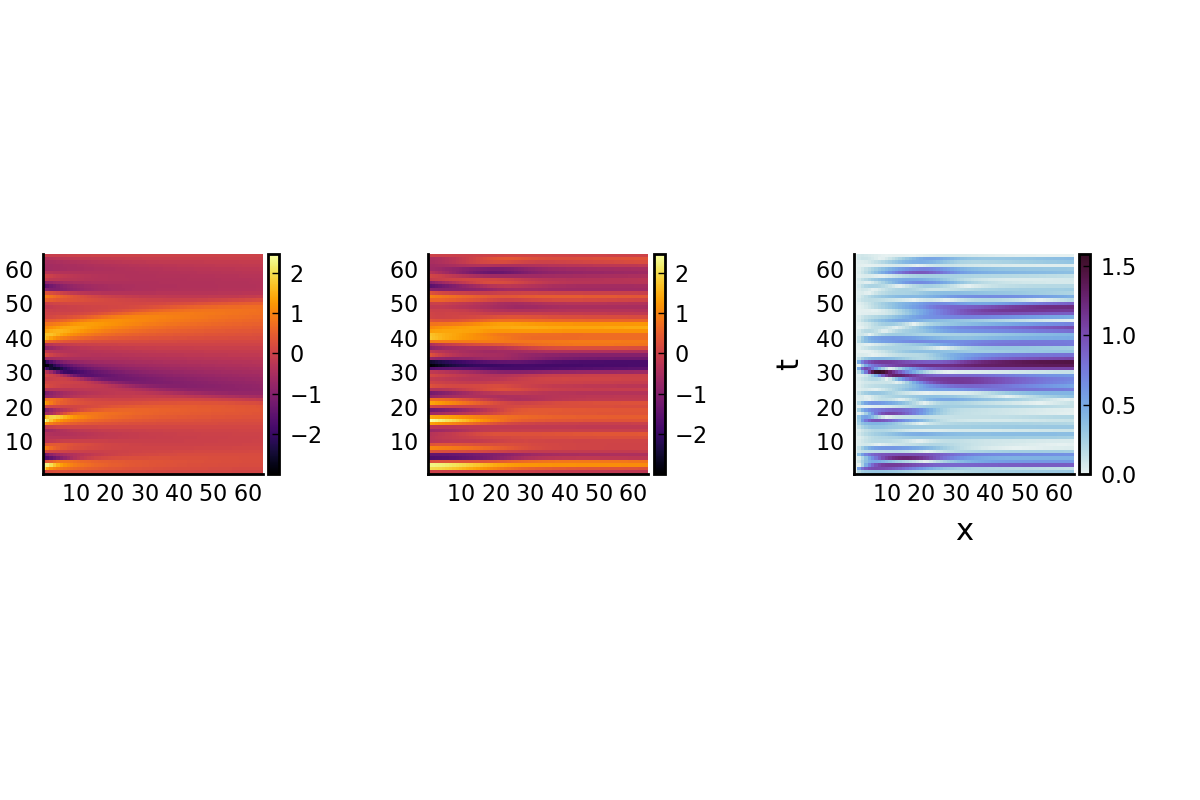

In [322]:
check_result(K, p, 2)

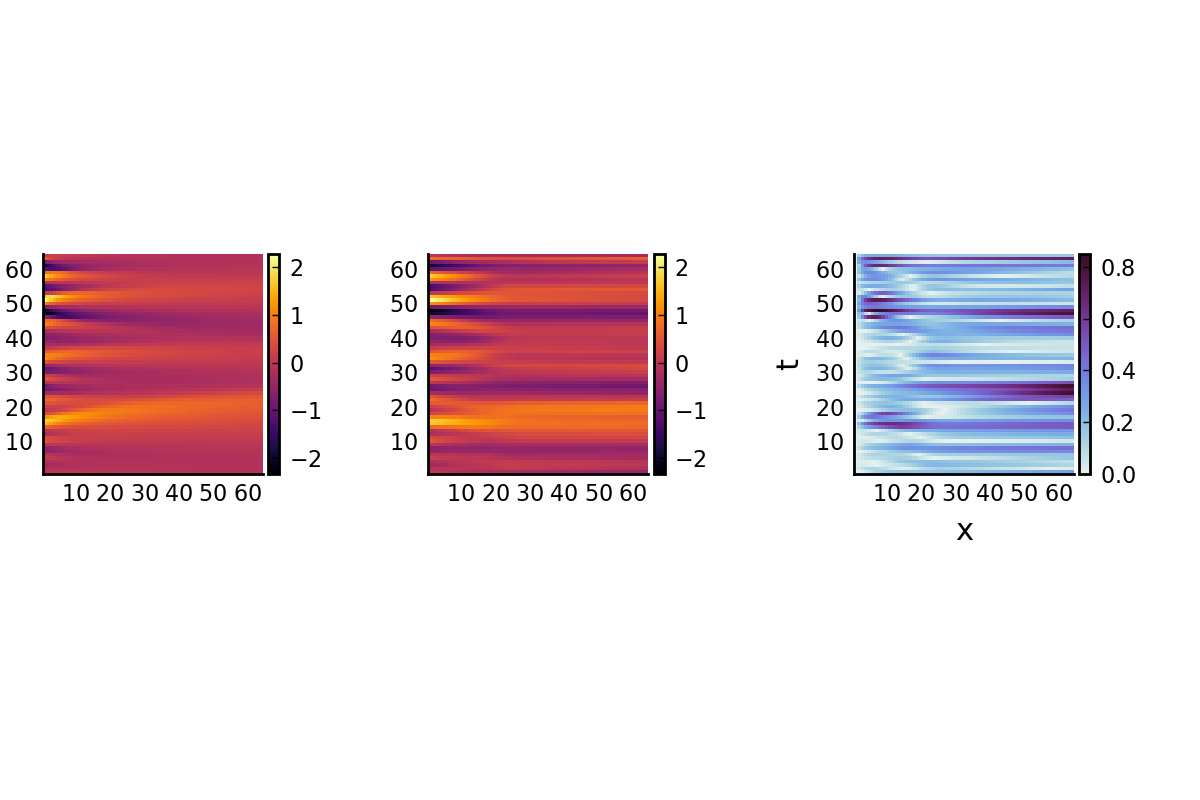

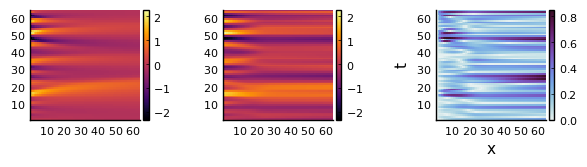

In [334]:
data = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_training_set.jld2")["training_set"];
t, u0, u = ProcessingTools.process_dataset(data, false);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Rosenbrock23(), saveat=t);
i = 43
u_pred = prob_neuralode(u0[:, i], p);
display(
    plot(
        GraphicTools.show_state(u[:, i, :], ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u[:, i, :], "");
        layout = (1, 3),
    )
)